# Simplicial Complexes and Data

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection

from sklearn.metrics import pairwise_distances

import gudhi as gd

## Simplicial Homology

In this notebook, we'll illustrate the *Vietoris-Rips complexes* of some toy datasets. 

This notebook uses the `gudhi` package, which I've found to be very useful for dealing with manipulating simplicial complexes.

Let's start by creating a toy dataset with some clustering structure.

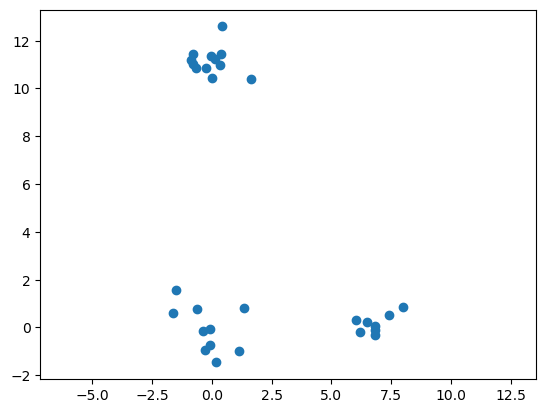

In [3]:
X1 = np.random.multivariate_normal([0,0],np.array([[1,0],[0,1]]),size = 10)
X2 = np.random.multivariate_normal([7,0],np.array([[1,0],[0,0.2]]),size = 8)
X3 = np.random.multivariate_normal([0,11],np.array([[1,0],[0,1]]),size = 12)

X = np.concatenate((X1,X2,X3))

plt.plot(X[:,0],X[:,1],'o')
plt.axis('equal')
plt.show()

## Back to Clustering

Recall that one of our motivations for studying topology in the context of data analysis was hierarchical clustering.

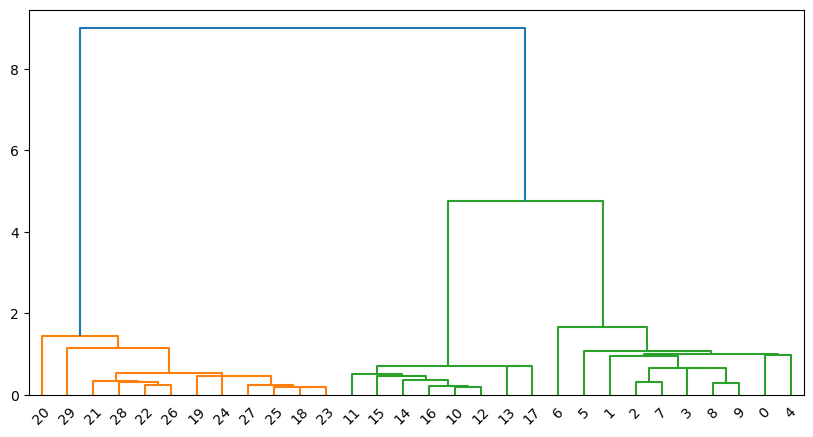

In [4]:
from scipy.cluster.hierarchy import dendrogram, linkage  

plt.figure(figsize=(10,5))
linked = linkage(X)
dendrogram(linked)
plt.show()

This gives a multiscale picture of the clustering structure of the data. As we showed in class, "clusters" in single linkage hierarchical clustering are connected components of a certain graph (or sequence of graphs) defined over the data.

Let's explore this.

## Creating a Growing Simplicial Complex

For each $r \geq 0$, define a simplicial complex $X_r = (V_r, \Sigma_r)$, where
$$
V_r = X \qquad \forall r
$$
and $\Sigma_r$ contains only $0$-simplices and $1$-simplices, where the $1$-simplices form the set
$$
\{\{x_i,x_j\} \mid x_i,x_j \in X, 0 < d(x_i,x_j) \leq r\},
$$
where $d(x_i,x_j)$ is Euclidean distance.

**Note:** $X_0 = X$, considered as a graph with no edges.

Let's write a function to generate such a simplicial complex for each $r \geq 0$. 

First we create a distance matrix for $X$.

In [5]:
from sklearn.metrics import pairwise_distances

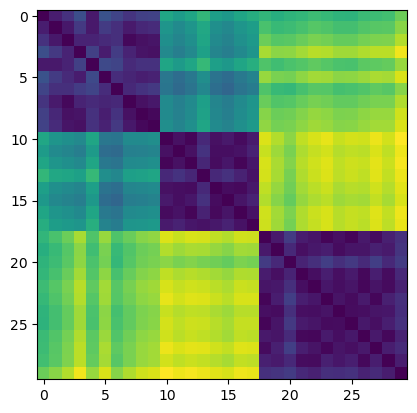

In [6]:
D = pairwise_distances(X)
plt.imshow(D)
plt.show()

For this simplicial complex, we can just use the `networkx` package, which is useful for calculations with graphs.

In [7]:
def create_simplicial_complex(D,r):
    """
    Input: distance matrix and nonnegative radius
    Output: networkx graph 
    """
    
    G = nx.Graph()
    G.add_nodes_from(list(range(len(D))))
    edge_list = np.argwhere(D <= r) 
    G.add_edges_from(edge_list)
    
    # Remove self-loops
    G.remove_edges_from(nx.selfloop_edges(G))
    
    return G

Try it out:

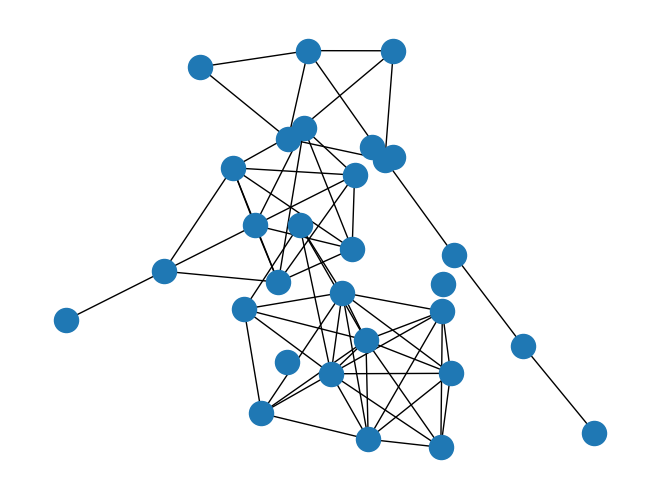

In [9]:
r = 1
G = create_simplicial_complex(D,r)
nx.draw_kamada_kawai(G)

It looks like the function works, but we would like our drawings to be more related to the original dataset. We can set node positions in `networkx` graphs (there are lots of other options for visualization here).

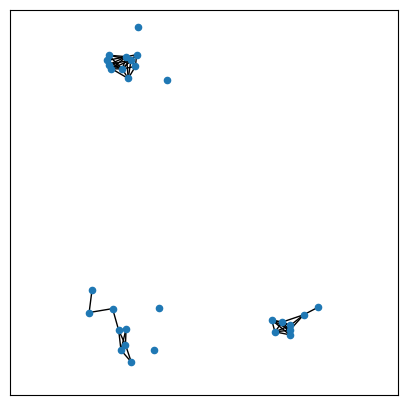

In [10]:
pos = {n:X[n,:] for n in range(len(X))}
plt.figure(figsize = (5,5))
nx.draw_networkx(G, pos = pos, with_labels = False,node_size = 20)
plt.axis('equal')
plt.show()

Now let's look at how this evolves over a few radii:

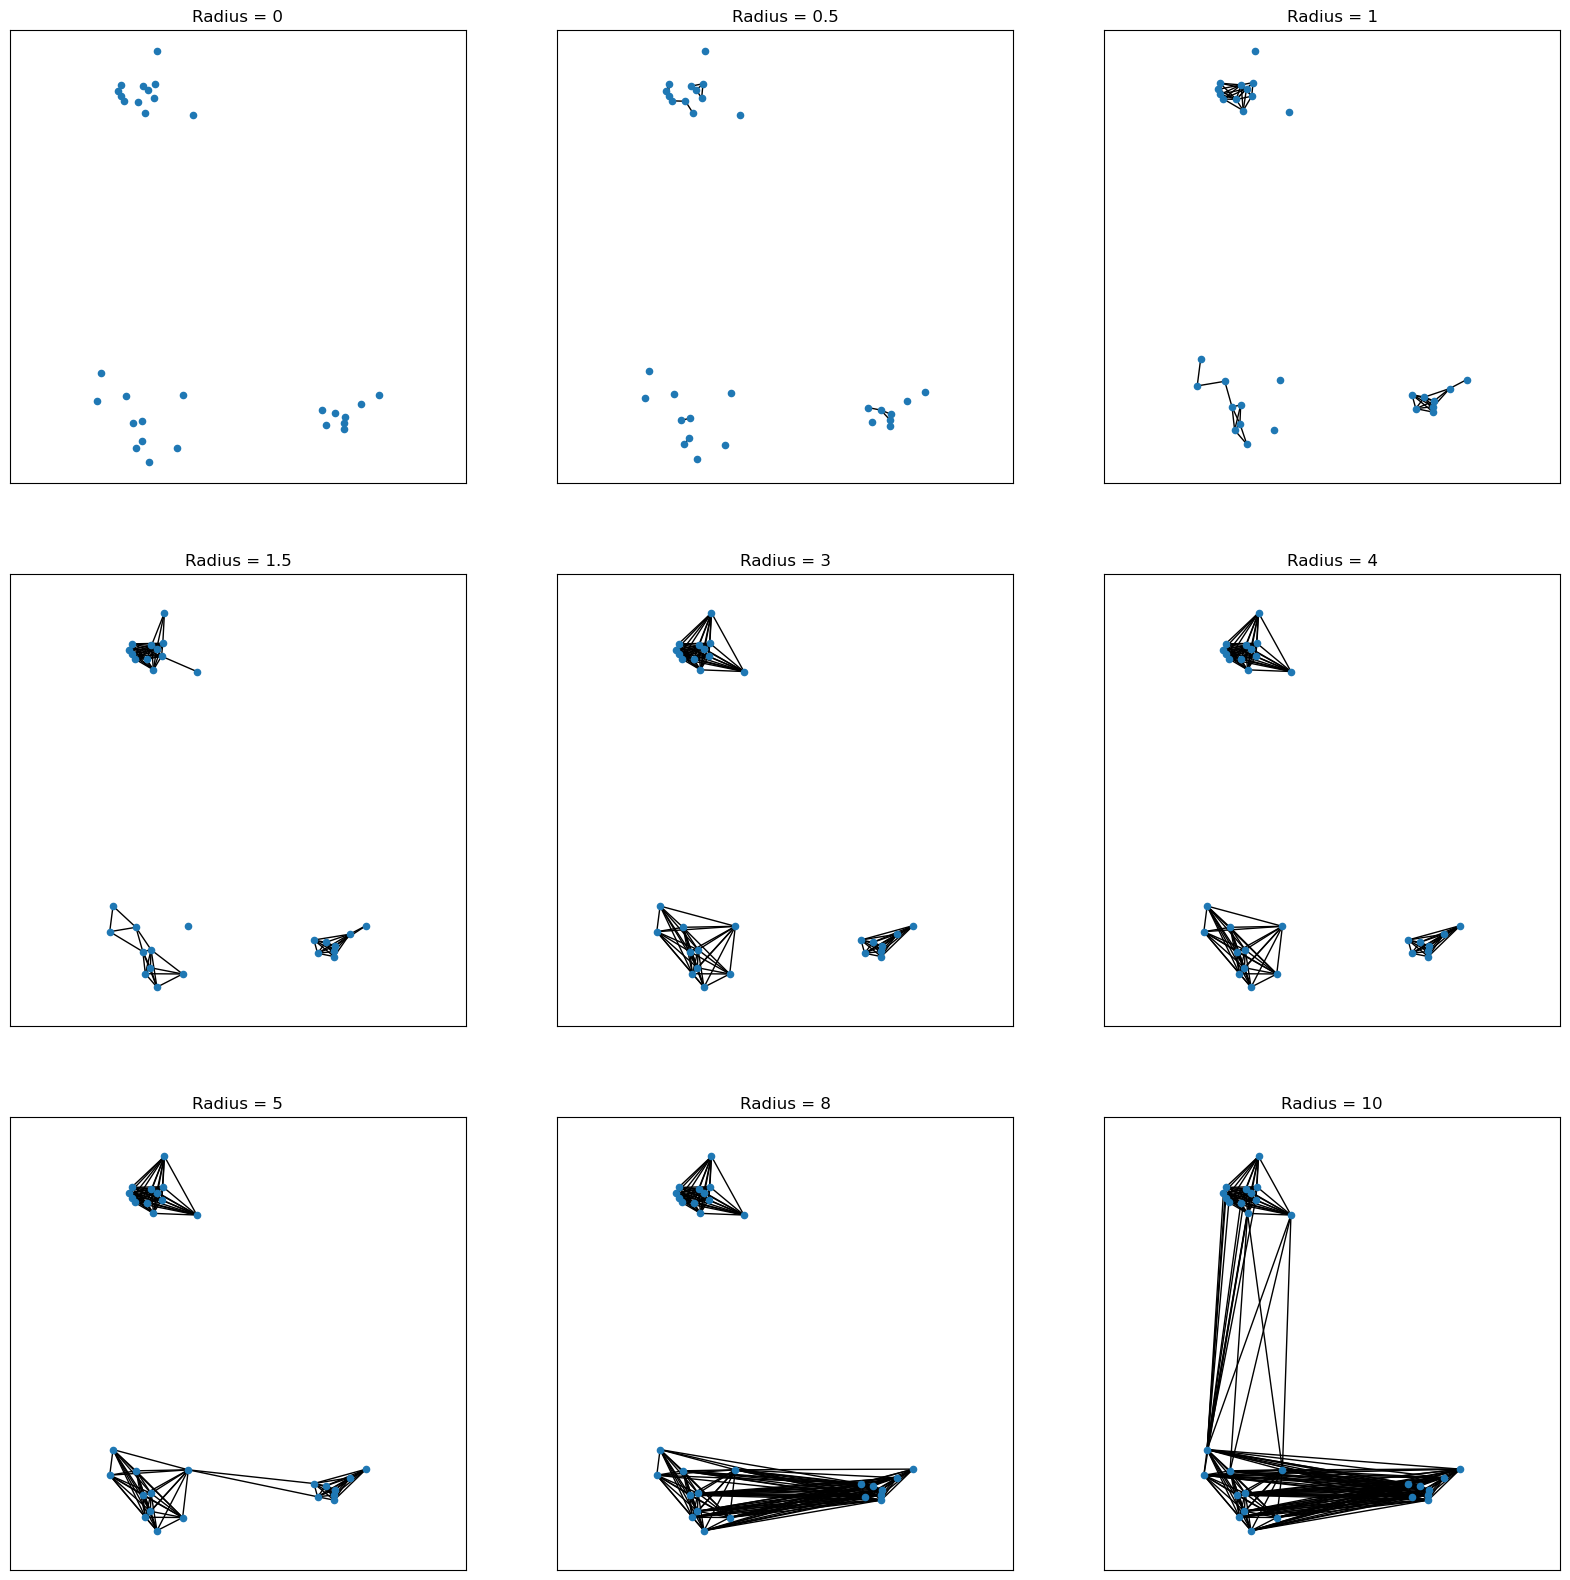

In [11]:
rs = [0,0.5,1,1.5,3,4,5,8,10]

plt.figure(figsize = (20,20))

for (j,r) in enumerate(rs):
    G = create_simplicial_complex(D,r)
    plt.subplot(3,3,j+1)
    nx.draw_networkx(G, pos = pos, with_labels = False,node_size = 20)
    plt.axis('equal')
    plt.title('Radius = '+str(r))

plt.show()

Compare again to the dendrogram from above.

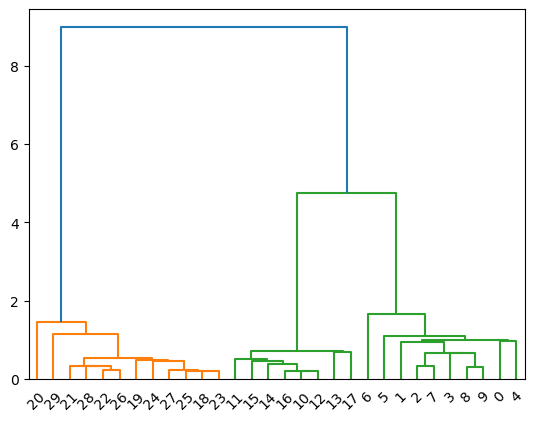

In [12]:
dendrogram(linked)
plt.show()

Observe that the heights where clusters merge correspond exactly to the radii $r$ where the corresponding connected components of the graphs merge.

## Vietoris-Rips Complexes

The above construction is (almost) an example of the concept of a *Vietoris-Rips complex*. Here is the general definition.

Let $(X,d)$ be a finite metric space and $r \geq 0$. We define the *Vietoris-Rips complex for $X$ at scale $r$* to be the simplicial complex $\mathrm{VR}_r(X) = (V_r,\Sigma_r)$, where $V_r = X$ for all $r$ and 
$$
\Sigma_r = \{(x_{i_0},\ldots,x_{i_k}) \mid 0 < d(x_{i_m},x_{i_n}) \leq r \; \forall \; m,n\}.
$$
The graphs we defined above are the $1$-skeleton of the Vietoris-Rips complexes at various scales; that is, they are the result of taking the Vietoris-Rips complex and throwing away any simplices with dimension $\geq 2$. This is sufficient to extract connectivity information about the data, but there is a reason to include higher-dimensional simplices in the construction.

## Higher-Dimensional Topological Features

Connected components are a *topological feature* of a graph. In particular, this is a "zero-dimensional feature" in the sense that components are destroyed by adding additional edges (1-dimensional objects). Roughly, a "$k$-dimensional feature" in a simplicial complex is a topological feature which can be destroyed by inserting $(k+1)$-dimensional simplices. This will be made precise when we define *simplicial homology*, later on. 


To see how higher-dimensional features would come into play, let's look at one more example.

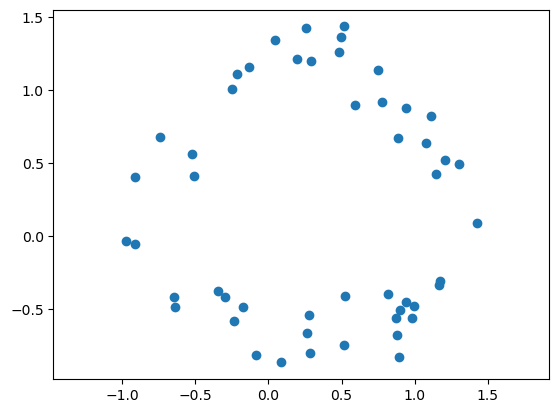

In [13]:
num_points = 50

X = np.random.multivariate_normal([0,0],np.array([[1,0],[0,1]]),size = num_points)
X = X.T/np.linalg.norm(X,axis = 1)
X = X.T + 0.5*np.random.rand(num_points,2)

plt.plot(X[:,0],X[:,1],'o')
plt.axis('equal')
plt.show()

In [14]:
D = pairwise_distances(X)

The $1$-skeleta of the Vietoris-Rips complexes look like this:

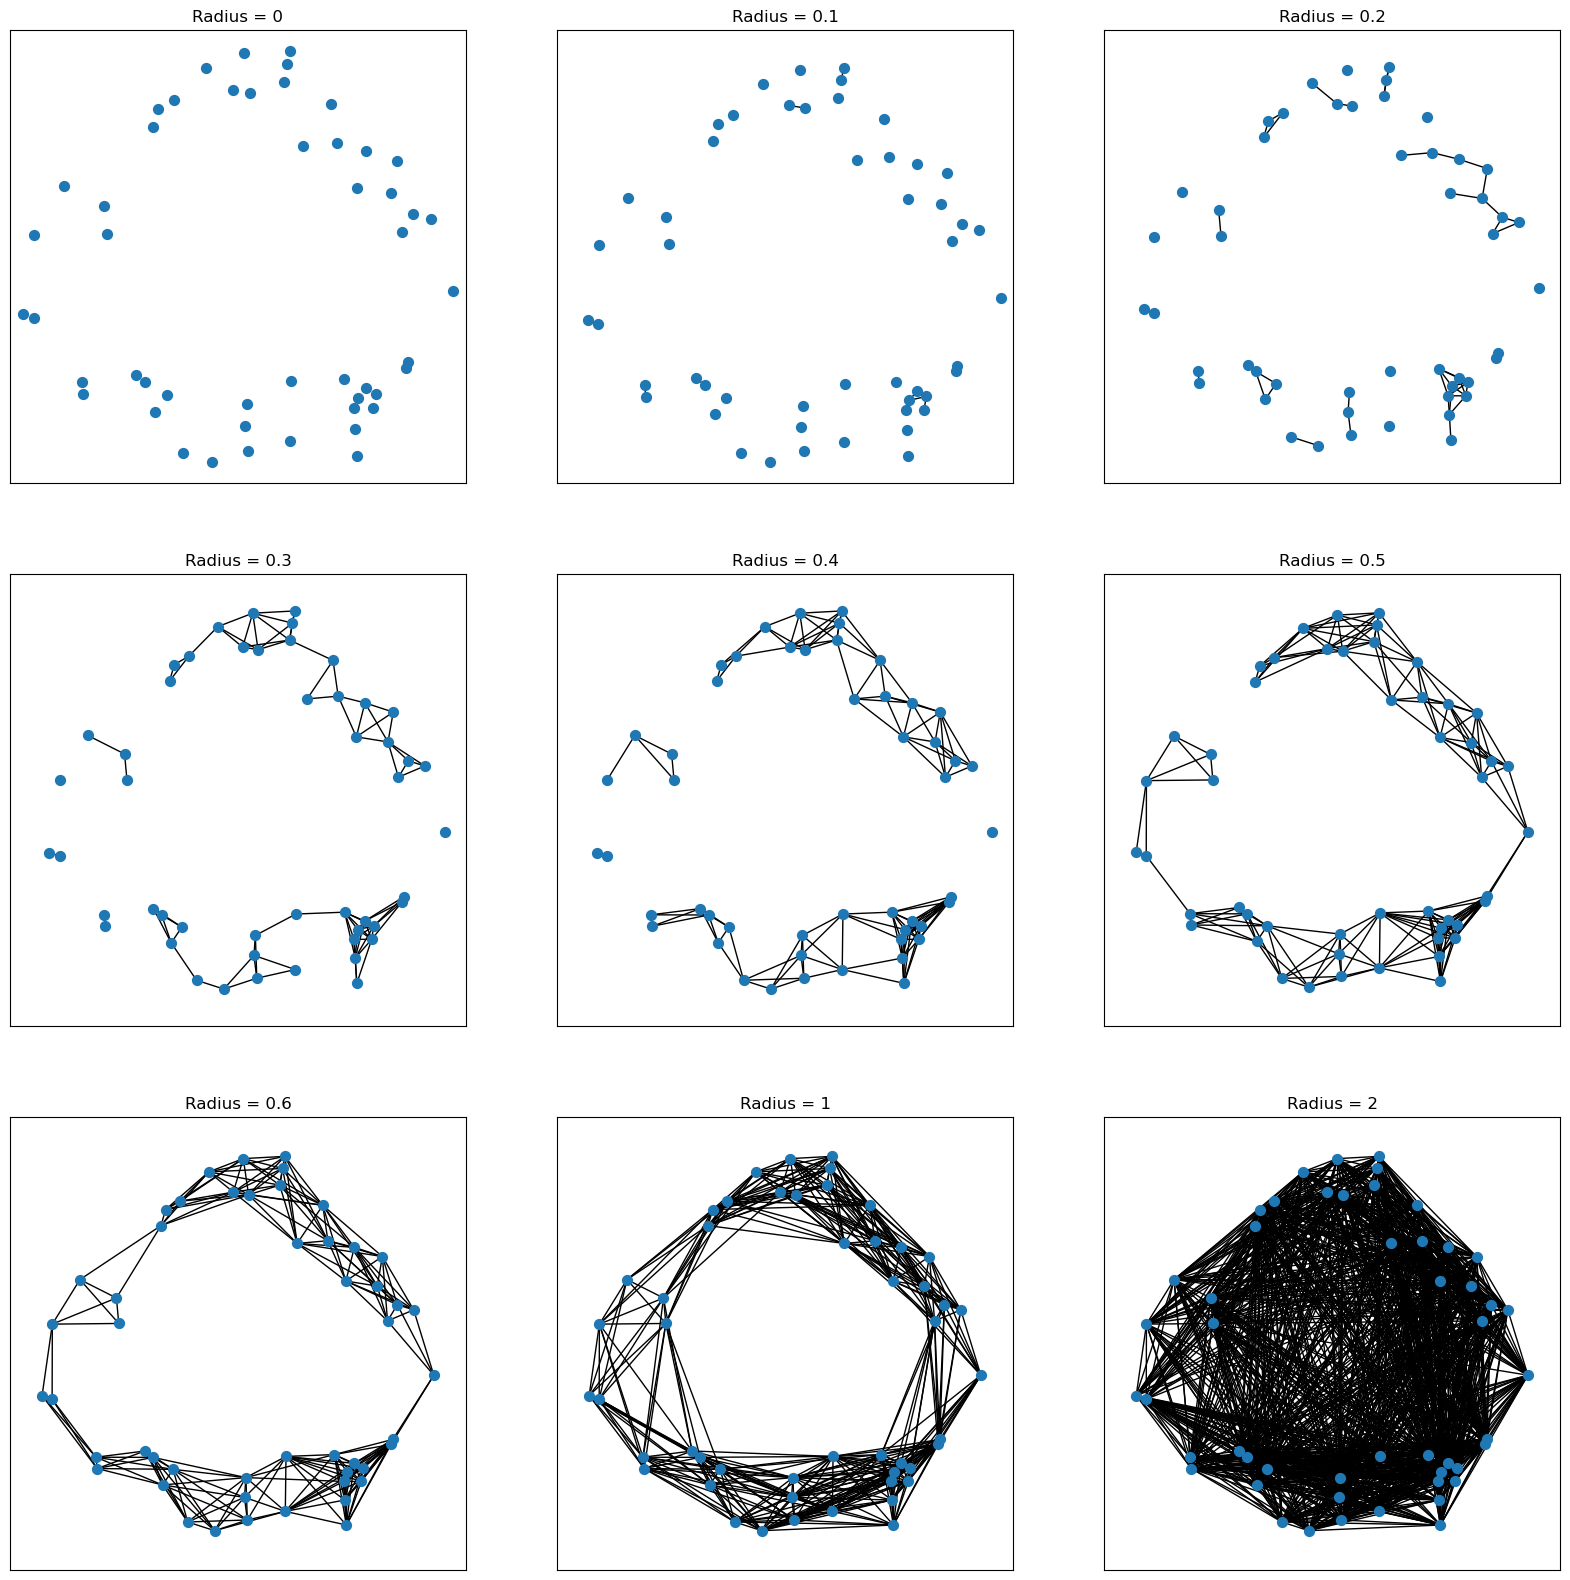

In [15]:
rs = [0,0.1,0.2,0.3,0.4,0.5,0.6,1,2]
pos = {n:X[n,:] for n in range(len(X))}

plt.figure(figsize = (20,20))

for (j,r) in enumerate(rs):
    G = create_simplicial_complex(D,r)
    plt.subplot(3,3,j+1)
    nx.draw_networkx(G, pos = pos, with_labels = False,node_size = 50)
    plt.axis('equal')
    plt.title('Radius = '+str(r))

plt.show()

For this dataset, there is a 'loop structure' which may be of interest. To see it computationally, we would want to track $1$-dimensional homology over various scales. As it stands, the 1-dimensional homology would see lots and lots of very small holes, which would not sufficiently accentuate the large apparent loop. We can remedy this by including higher-dimensional simplices.

In what follows, I'll compute the $2$-skeleton of the Vietoris-Rips complexes. This will allow us to see "1-dimensional features" of the dataset. These correspond to "unfilled loops" in the simplicial complex.

Let's work at a fixed resolution to design the plotting tool.

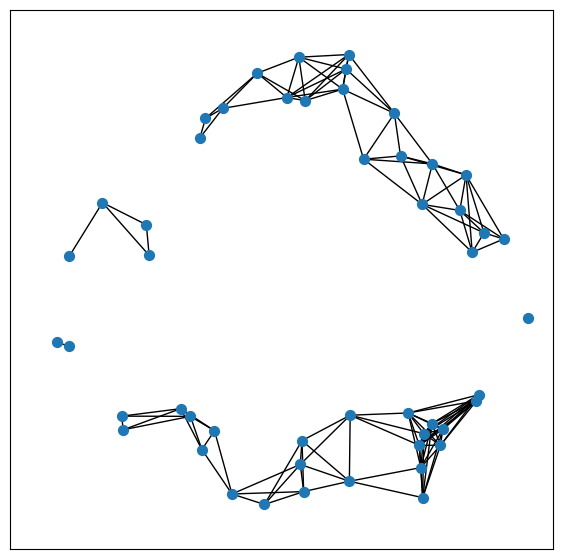

In [16]:
plt.figure(figsize = (7,7))
r = 0.4
G = create_simplicial_complex(D,r)
nx.draw_networkx(G, pos = pos, with_labels = False,node_size = 50)
plt.axis('equal')
plt.show()

In [17]:
def create_2_dim_simplicial_complex(D,r):
    
    # Create 1-skeleton
    G = create_simplicial_complex(D,r)
    
    # Get a list of 2-simplices
    two_spx_list = []
    
    # Naive search for viable 2-simplices
    for edge in G.edges():
        for vertex in G.nodes():
            if vertex != edge[0] and vertex != edge[1] and D[edge[0],vertex] < r and D[edge[1],vertex] < r:
                two_spx_list.append([edge[0],edge[1],vertex])
                
    return G, two_spx_list

In [18]:
G, two_spx_list = create_2_dim_simplicial_complex(D,r)
two_spx_list

[[0, 7, 48],
 [0, 33, 48],
 [0, 48, 7],
 [0, 48, 33],
 [1, 4, 10],
 [1, 4, 13],
 [1, 4, 27],
 [1, 4, 30],
 [1, 4, 38],
 [1, 4, 40],
 [1, 10, 4],
 [1, 10, 13],
 [1, 10, 27],
 [1, 10, 30],
 [1, 10, 38],
 [1, 10, 40],
 [1, 13, 4],
 [1, 13, 10],
 [1, 13, 27],
 [1, 13, 30],
 [1, 13, 38],
 [1, 13, 40],
 [1, 27, 4],
 [1, 27, 10],
 [1, 27, 13],
 [1, 27, 30],
 [1, 27, 38],
 [1, 27, 40],
 [1, 30, 4],
 [1, 30, 10],
 [1, 30, 13],
 [1, 30, 27],
 [1, 30, 38],
 [1, 30, 40],
 [1, 38, 4],
 [1, 38, 10],
 [1, 38, 13],
 [1, 38, 27],
 [1, 38, 30],
 [1, 38, 40],
 [1, 40, 4],
 [1, 40, 10],
 [1, 40, 13],
 [1, 40, 27],
 [1, 40, 30],
 [1, 40, 38],
 [2, 16, 35],
 [2, 21, 28],
 [2, 21, 46],
 [2, 28, 21],
 [2, 28, 46],
 [2, 35, 16],
 [2, 46, 21],
 [2, 46, 28],
 [3, 29, 49],
 [3, 49, 29],
 [4, 10, 1],
 [4, 10, 12],
 [4, 10, 13],
 [4, 10, 27],
 [4, 10, 30],
 [4, 10, 38],
 [4, 10, 40],
 [4, 10, 41],
 [4, 12, 10],
 [4, 12, 13],
 [4, 12, 27],
 [4, 12, 30],
 [4, 12, 38],
 [4, 12, 41],
 [4, 13, 1],
 [4, 13, 10],
 [4, 13,

To draw the simplices, we'll use the `Polygon` function imported above. We'll add the triangles one-by-one to a collection, then use plotting tools to display them.

In [19]:
patches = []

for i,spx in enumerate(two_spx_list):
    position_array = np.array([[pos[vert][0],pos[vert][1]] for vert in spx])
    polygon = Polygon(position_array, closed = True)
    patches.append(polygon)

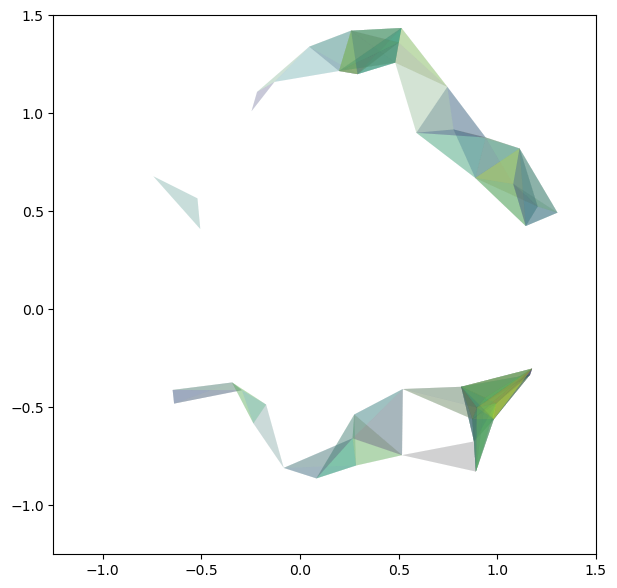

In [20]:
fig, ax = plt.subplots(figsize = (7,7))

colors = 100*np.random.rand(len(patches))
p = PatchCollection(patches, alpha=0.1)
p.set_array(np.array(colors))
ax.add_collection(p)

plt.xlim([-1.25, 1.5])
plt.ylim([-1.25, 1.5])
plt.show()

Now we'll plot the 1-skeleton first and overlay the triangles.

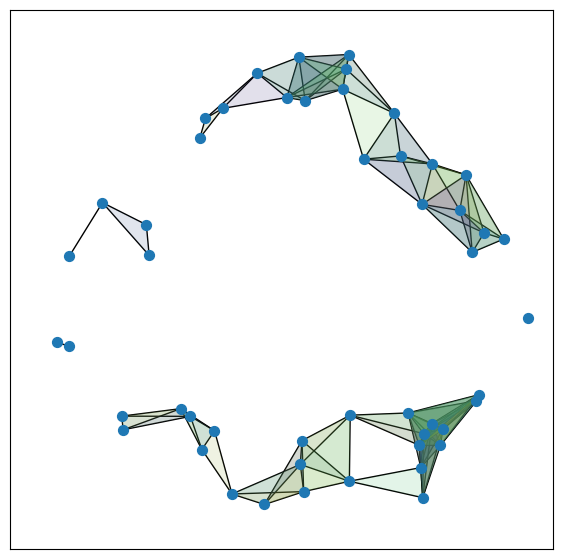

In [21]:
fig, ax = plt.subplots(figsize = (7,7))

nx.draw_networkx(G, pos = pos, with_labels = False,node_size = 50)
colors = 100*np.random.rand(len(patches))
p = PatchCollection(patches, alpha=0.05)
p.set_array(np.array(colors))
ax.add_collection(p)

plt.axis('equal')
plt.show()

Looks good! Now let's run it on a range of radii. We'll decrease the max radius in our pictures, since the number of triangles blows up factorially and it eventually takes forever to draw all of them.

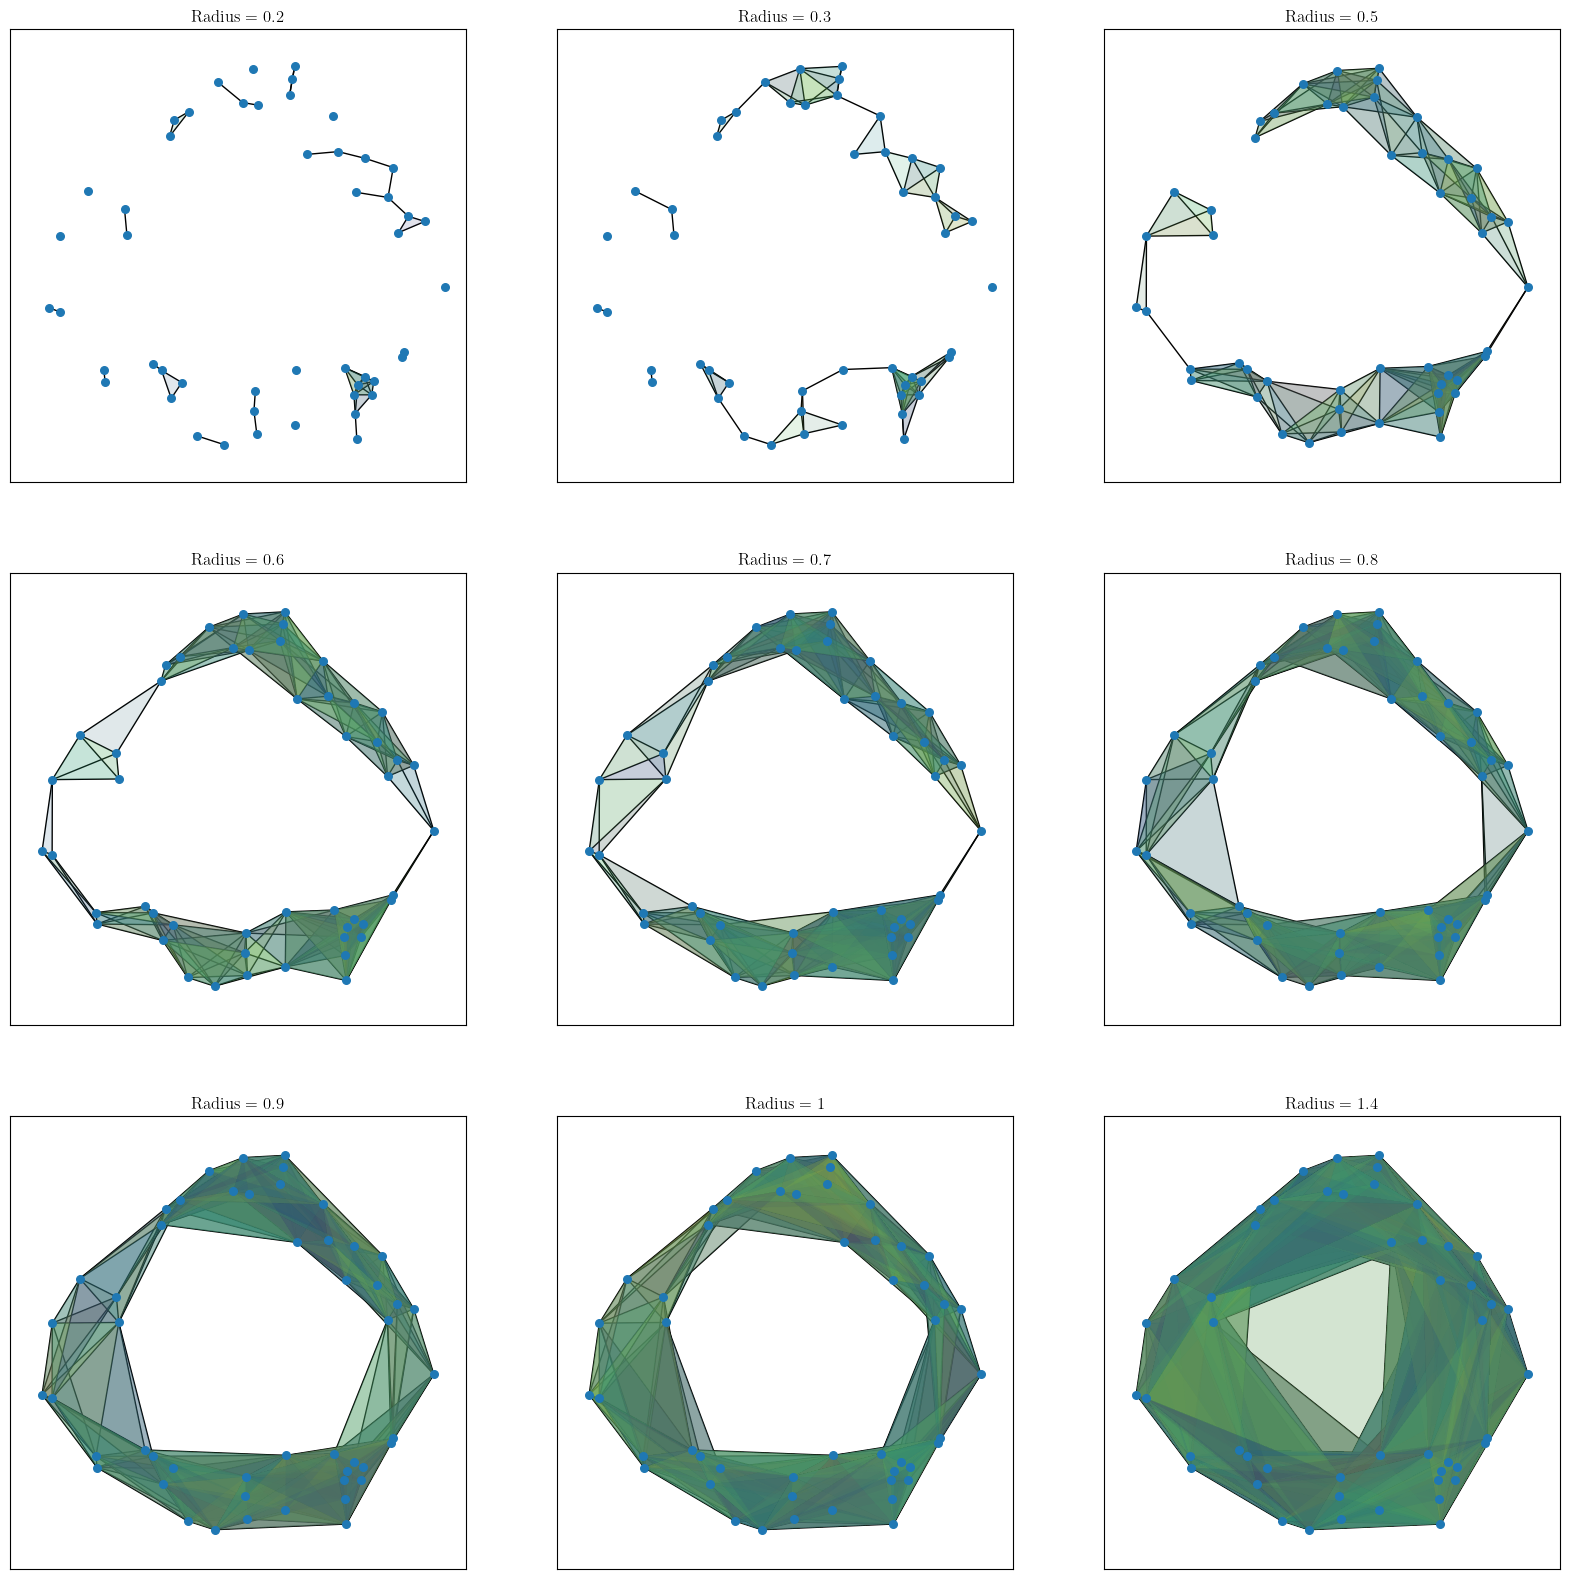

In [29]:
rs = [0.2,0.3,0.5,0.6,0.7,0.8,0.9,1,1.4]
pos = {n:X[n,:] for n in range(len(X))}

plt.figure(figsize = (20,20))

for (j,r) in enumerate(rs):
    G, two_spx_list = create_2_dim_simplicial_complex(D,r)
    patches = []

    for i,spx in enumerate(two_spx_list):
        position_array = np.array([[pos[vert][0],pos[vert][1]] for vert in spx])
        polygon = Polygon(position_array, closed = True)
        patches.append(polygon)
        
    ax = plt.subplot(3,3,j+1)
    nx.draw_networkx(G, pos = pos, with_labels = False,node_size = 30)
    colors = 100*np.random.rand(len(patches))
    p = PatchCollection(patches, alpha=0.05)
    p.set_array(np.array(colors))
    ax.add_collection(p)
    
    plt.axis('equal')
    plt.title('Radius = '+str(r))

plt.show()

We see that loops appear in the data:
- small loops appear earlier in the process but are quickly filled in
- a much stronger loop appears a bit later but persists for a long time
- the large loop will also eventually be filled in, but the idea is that keep track of how features change over 'filtration values' (values of $r$).

## Persistent Homology

## Persistence Diagrams and Barcodes

We haven't defined everything that we'll need formally, but let's start to explore *peristent homology* at an intuitive level. This is one of the main tools of TDA.

Let's first study the dataset that we were looking at above. In `gudhi`, we create the Vietoris-Rips complex using the following functions. I'm passing in some options which will only construct the $2$-skeleton of the VR complex.

In [23]:
skeleton = gd.RipsComplex(distance_matrix = D, max_edge_length = 2) 
Rips_complex = skeleton.create_simplex_tree(max_dimension = 2)

The VR complex is stored as a simplicial complex, together with a 'filtration' value for the simplex. This is the radius at which the simplex first appears in $\mathrm{VR}_r(X)$. 

Let's see how many simplices there are and print off the first couple of hundred to see what the structure looks like.

In [24]:
rips_filtration = Rips_complex.get_filtration()
rips_list = list(rips_filtration)
print('Number of Simplices:',len(rips_list))
for splx in rips_list[0:200] :
    print(splx)

Number of Simplices: 14879
([0], 0.0)
([1], 0.0)
([2], 0.0)
([3], 0.0)
([4], 0.0)
([5], 0.0)
([6], 0.0)
([7], 0.0)
([8], 0.0)
([9], 0.0)
([10], 0.0)
([11], 0.0)
([12], 0.0)
([13], 0.0)
([14], 0.0)
([15], 0.0)
([16], 0.0)
([17], 0.0)
([18], 0.0)
([19], 0.0)
([20], 0.0)
([21], 0.0)
([22], 0.0)
([23], 0.0)
([24], 0.0)
([25], 0.0)
([26], 0.0)
([27], 0.0)
([28], 0.0)
([29], 0.0)
([30], 0.0)
([31], 0.0)
([32], 0.0)
([33], 0.0)
([34], 0.0)
([35], 0.0)
([36], 0.0)
([37], 0.0)
([38], 0.0)
([39], 0.0)
([40], 0.0)
([41], 0.0)
([42], 0.0)
([43], 0.0)
([44], 0.0)
([45], 0.0)
([46], 0.0)
([47], 0.0)
([48], 0.0)
([49], 0.0)
([1, 40], 0.032650067940302514)
([10, 13], 0.06243515973169248)
([17, 23], 0.06325248023949306)
([27, 30], 0.06350421409911787)
([5, 34], 0.06557017593896813)
([10, 30], 0.06673555170957023)
([9, 15], 0.06996357197461528)
([18, 32], 0.07551730499335998)
([4, 13], 0.08209507974613596)
([6, 45], 0.09506955537455225)
([13, 30], 0.09954727983909391)
([10, 13, 30], 0.09954727983909391)

Okay... so now we have a VR complex. But what do we do with it? The following code computes the persistence module for the Vietoris-Rips complex and represents it in a particular way.

In [25]:
BarCodes = Rips_complex.persistence()

Looking at the result...

In [26]:
BarCodes

[(1, (0.5219380736754433, 1.3115610127499722)),
 (1, (0.21325673603578968, 0.2700502420538821)),
 (1, (0.37158208652609426, 0.40171518483274077)),
 (1, (0.2482257256047131, 0.2635918246298188)),
 (0, (0.0, inf)),
 (0, (0.0, 0.4679168714817573)),
 (0, (0.0, 0.4462252864853178)),
 (0, (0.0, 0.4429297728333011)),
 (0, (0.0, 0.41993965073592004)),
 (0, (0.0, 0.3217762462150625)),
 (0, (0.0, 0.30357310884392424)),
 (0, (0.0, 0.2964527759315746)),
 (0, (0.0, 0.29197430681966974)),
 (0, (0.0, 0.2782339003420121)),
 (0, (0.0, 0.2743638945614095)),
 (0, (0.0, 0.2518004151479177)),
 (0, (0.0, 0.2509061131644488)),
 (0, (0.0, 0.23925528445210564)),
 (0, (0.0, 0.225570151593954)),
 (0, (0.0, 0.2195229247354535)),
 (0, (0.0, 0.21479391100015277)),
 (0, (0.0, 0.21099062979185715)),
 (0, (0.0, 0.20003191339935944)),
 (0, (0.0, 0.19535355478596347)),
 (0, (0.0, 0.1949037937967033)),
 (0, (0.0, 0.18918264714327382)),
 (0, (0.0, 0.1842444200118676)),
 (0, (0.0, 0.18099739123552008)),
 (0, (0.0, 0.174128

So it's a bunch of things of the form $(d,(x,y))$. We can plot these things in a couple of ways. Let's see if we can guess what this representation is telling us about the data.

The following is called a *barcode representation*.

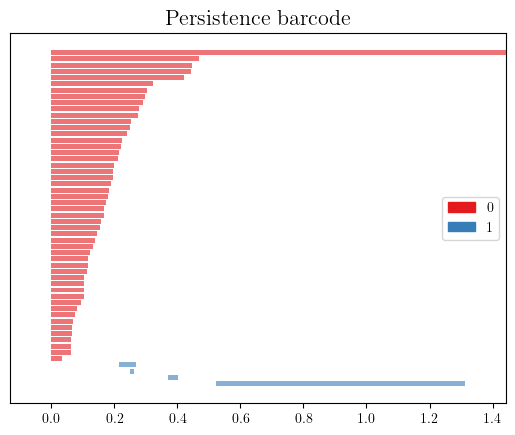

In [27]:
gd.plot_persistence_barcode(BarCodes)
plt.show()

The red lines are the barcode associated to the dendrogram of the data, as we discussed in class.

The blue lines are the barcode for the 1-dimensional features of the dataset. They represenent loops which appear and are later filled in, in the data as the $r$ parameter increases. 

## Another Example

Let's run this pipeline on one more example to get an intuitive feel for how it works.

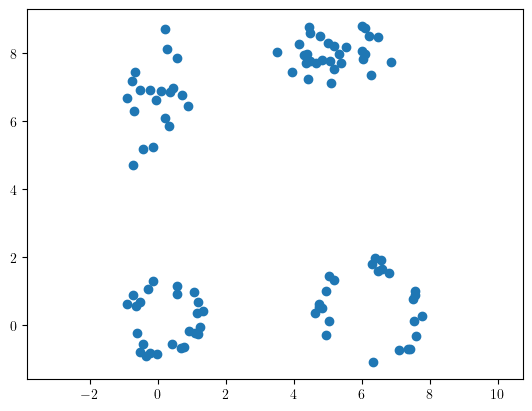

In [30]:
A = np.random.multivariate_normal([0,0],np.array([[1,0],[0,1]]),size = 25)
A = A.T/np.linalg.norm(A,axis = 1)
A = A.T + 0.5*np.random.rand(25,2)

Y = np.random.multivariate_normal([0,0],np.array([[1,0],[0,1]]),size = 25)
Y = 1.5*Y.T/np.linalg.norm(Y,axis = 1)
Y = Y.T + 0.5*np.random.rand(25,2) + [6,0]

Z1 = np.random.multivariate_normal([0,7],np.array([[0.2,0],[0,1]]),size = 20)
Z2 = np.random.multivariate_normal([5,8],np.array([[1,0],[0,0.2]]),size = 30)

X = np.concatenate((A,Y,Z1,Z2))

plt.plot(X[:,0],X[:,1],'o')
plt.axis('equal')
plt.show()

In [31]:
D = pairwise_distances(X)

Radius 0 done...
Radius 0.25 done...
Radius 0.5 done...
Radius 0.75 done...
Radius 1 done...
Radius 1.25 done...
Radius 1.5 done...
Radius 2 done...
Radius 2.5 done...


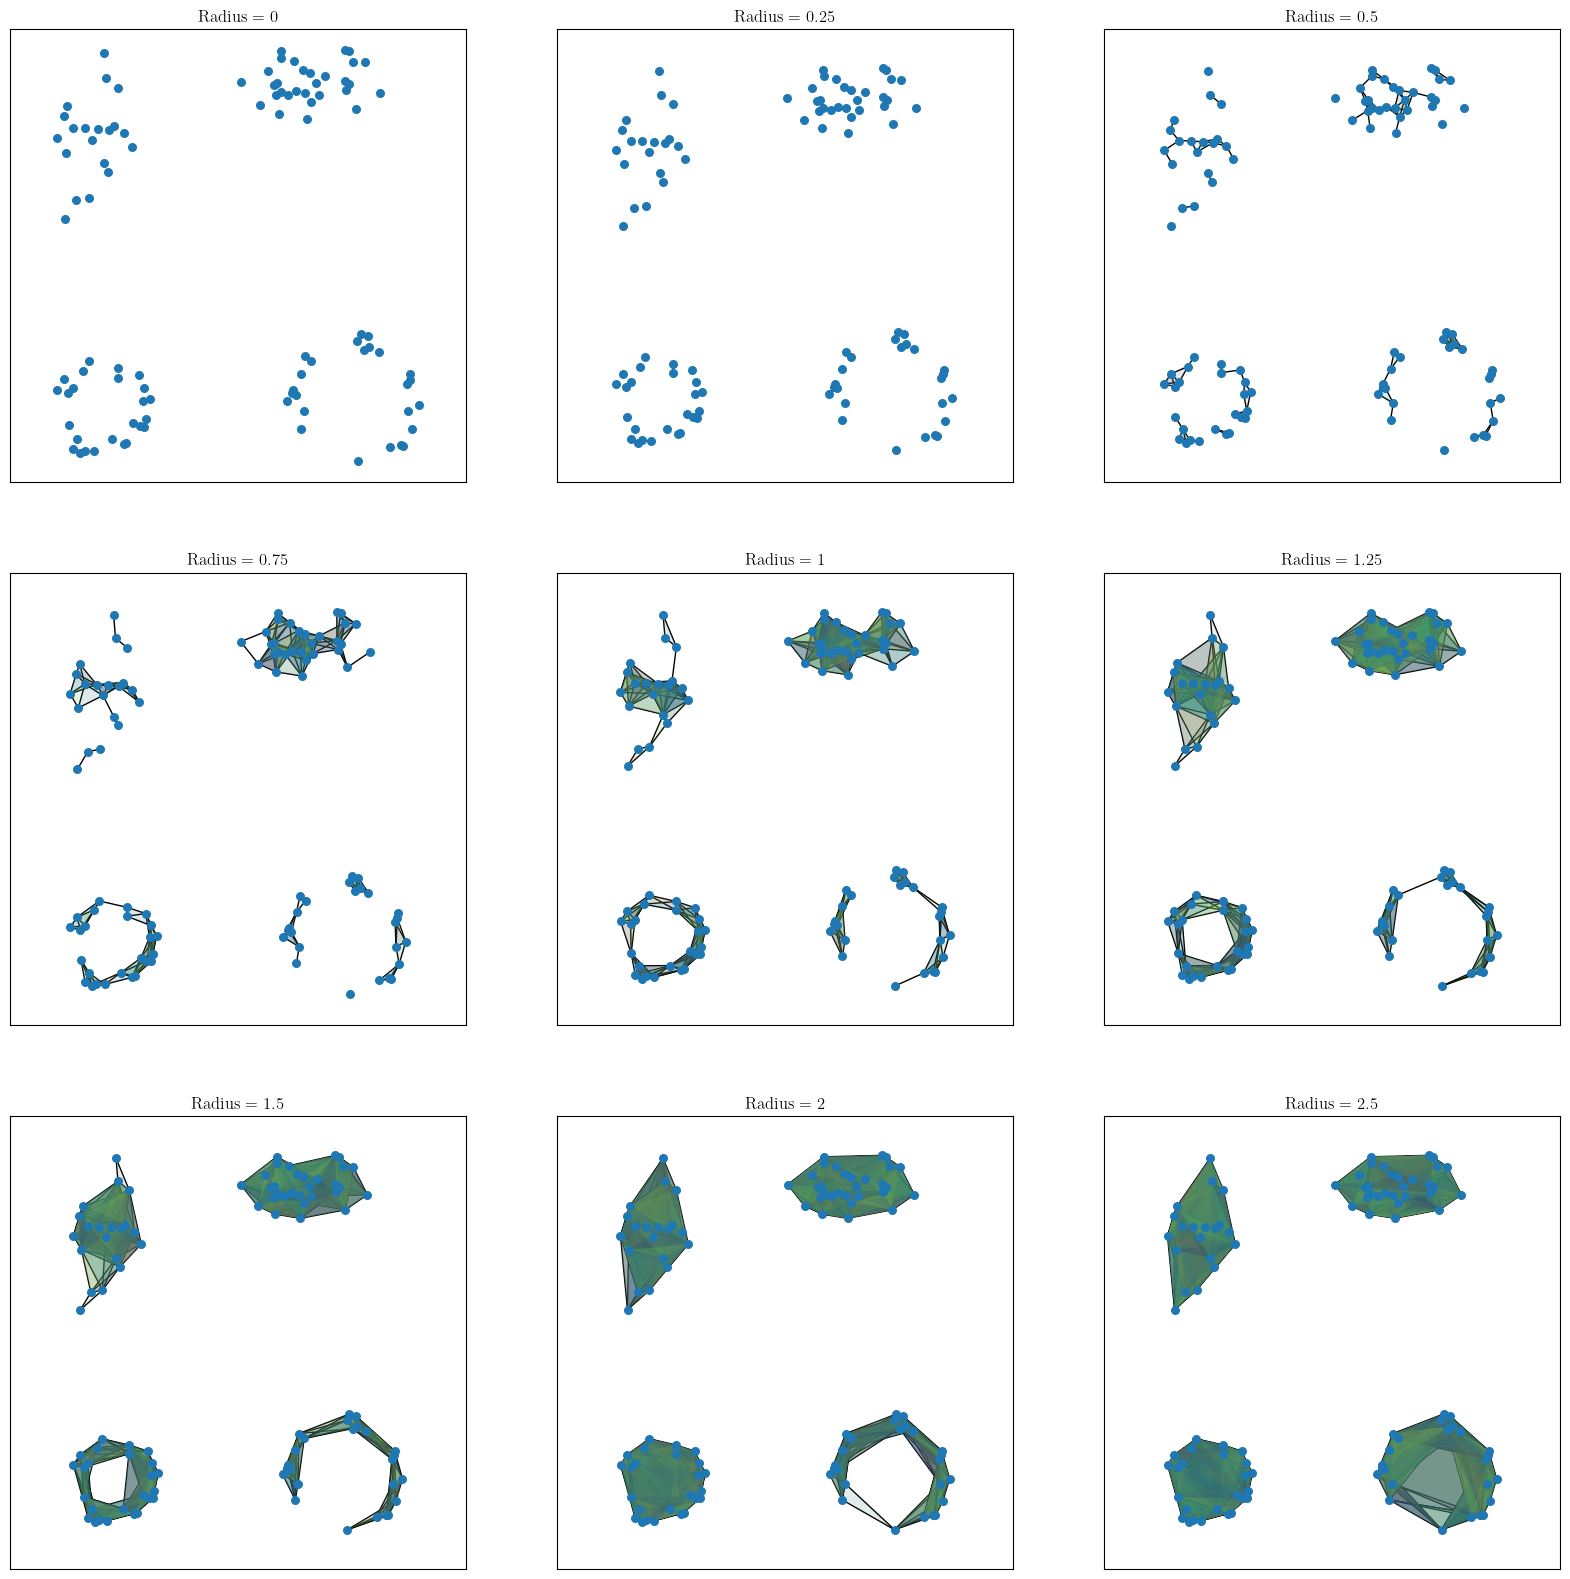

In [32]:
rs = [0,0.25,0.5,0.75,1,1.25,1.5,2,2.5]
pos = {n:X[n,:] for n in range(len(X))}

plt.figure(figsize = (20,20))

for (j,r) in enumerate(rs):
    G, two_spx_list = create_2_dim_simplicial_complex(D,r)
    patches = []

    for i,spx in enumerate(two_spx_list):
        position_array = np.array([[pos[vert][0],pos[vert][1]] for vert in spx])
        polygon = Polygon(position_array, closed = True)
        patches.append(polygon)
        
    ax = plt.subplot(3,3,j+1)
    nx.draw_networkx(G, pos = pos, with_labels = False,node_size = 30)
    colors = 100*np.random.rand(len(patches))
    p = PatchCollection(patches, alpha=0.05)
    p.set_array(np.array(colors))
    ax.add_collection(p)
    
    print('Radius',r,'done...')
    
    plt.axis('equal')
    plt.title('Radius = '+str(r))

plt.show()

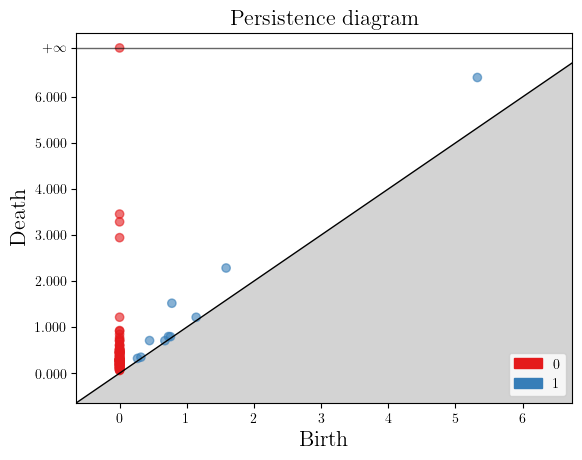

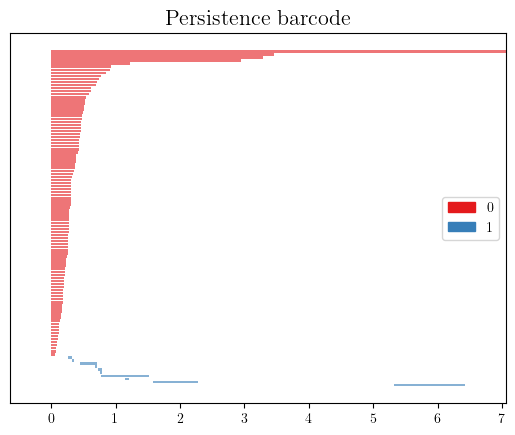

In [33]:
skeleton = gd.RipsComplex(distance_matrix = D, max_edge_length = 10) 
Rips_complex = skeleton.create_simplex_tree(max_dimension = 2)
BarCodes = Rips_complex.persistence()

gd.plot_persistence_diagram(BarCodes)
plt.show()

gd.plot_persistence_barcode(BarCodes)
plt.show()

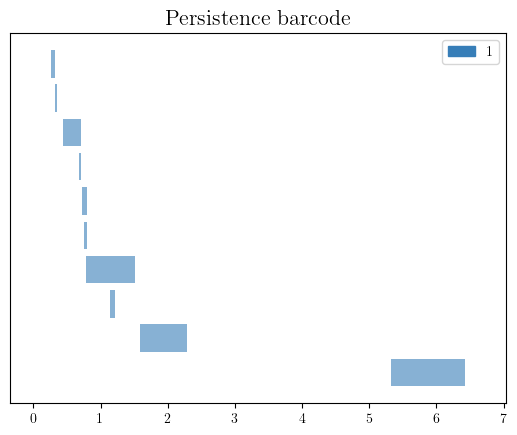

In [34]:
gd.plot_persistence_barcode([bar for bar in BarCodes if bar[0] == 1])
plt.show()

## Next Steps

Our plan moving forward is to precisely define *homology* and *persistent homology*, and to then understand what the points in the persistence diagram/bars in the barcodes represent. 